## Welcome

This is material for the **Matching and Subclassification** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [1]:
import pandas as pd
import numpy as np
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)
    

In [3]:
## Simple Difference in Outcomes
titanic = read_data("titanic.dta")

titanic['d'] = 0
titanic.loc[titanic['class']=='1st class', 'd'] = 1

titanic['sex_d'] = 0
titanic.loc[titanic['sex']=='man', 'sex_d'] = 1

titanic['age_d'] = 0
titanic.loc[titanic['age']=='adults', 'age_d'] = 1

titanic['survived_d'] = 0
titanic.loc[titanic['survived']=='yes', 'survived_d'] = 1


In [4]:
ey0 = titanic.loc[titanic['d']==0, 'survived_d'].mean()
ey1 = titanic.loc[titanic['d']==1, 'survived_d'].mean()

sdo = ey1 - ey0
print("The simple difference in outcomes is {:.2%}".format(sdo))

The simple difference in outcomes is 35.38%


In [5]:
## Weighted Average Treatment Effect 
titanic['s'] = 0 
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==1), 's'] = 1
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==0), 's'] = 2
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==1), 's'] = 3
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==0), 's'] = 4

obs = titanic.shape[0]

def weighted_avg_effect(df):
    diff = df[df.d==1].survived_d.mean() - df[df.d==0].survived_d.mean()
    weight = df[df.d==0].shape[0]/obs
    return diff*weight

wate = titanic.groupby('s').apply(weighted_avg_effect).sum()

print("The weigthted average treatment effect estimate is {:.2%}".format(wate))

The weigthted average treatment effect estimate is 16.09%


# Questions
- Using the simple difference in outcomes, how much does the probability of survival increase for first-class passengers relative to some control group?
- Explain in your own words what stratifying on gender and age did for this difference in outcomes between treatment and control?
- After stratifying on gender and age, what happens to the difference in probability of survival between first-class and non-first-class passengers?



## Training Example

First, we will look at the distribution of age between the treated and non-treated groups

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 14 rows containing non-finite values.


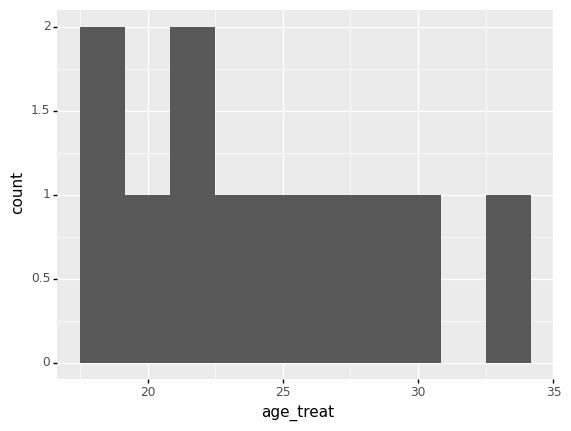

<ggplot: (8765026733050)>

In [6]:
training_example = read_data("training_example.dta") 

p.ggplot(training_example, p.aes(x='age_treat')) +\
  p.stat_bin(bins = 10)

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


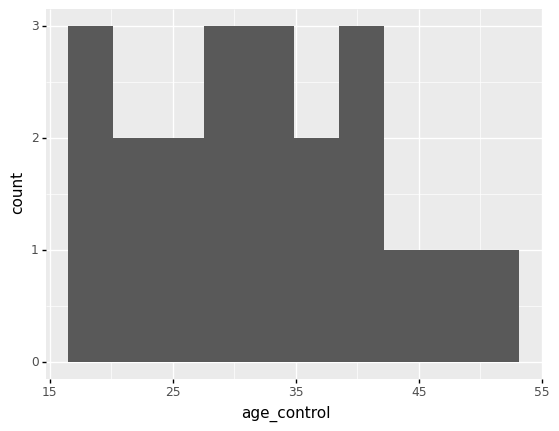

<ggplot: (8765026732969)>

In [7]:
p.ggplot(training_example, p.aes(x='age_control')) +\
  p.geom_histogram(bins = 10)

#### Questions

- Compare the distribution of ages between the treated and the control groups. How do they differ, if at all?


In [8]:
training_bias_reduction = read_data("training_bias_reduction.dta") 

training_bias_reduction['Y1'] = 0
training_bias_reduction.loc[training_bias_reduction['Unit'].isin(range(1,5)), 'Y1'] = 1
training_bias_reduction['Y0'] = (4,0,5,1,4,0,5,1)


train_reg = sm.OLS.from_formula('Y ~ X', training_bias_reduction).fit()
training_bias_reduction['u_hat0'] = train_reg.predict(training_bias_reduction)
training_bias_reduction = training_bias_reduction[['Unit', 'Y1', 'Y0', 'Y', 'D', 'X', 'u_hat0']]


## National Supported Work Demonstration Experiment

To compare results, let's first look at the treatment effect identified by a true experiment.


In [9]:
nsw_dw = read_data('nsw_mixtape.dta')

mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.35


#### Questions
- How do you interpret the above estimated ATE?
- Say you were interested in the ATT.  Can you report the ATT from a randomized experiment?  If so, what is it? If not, why not?



Now, lets turn to a non-experimental control group. We first have to load the data from the CPS. and estimate the propensity score


In [10]:
# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)


In [11]:
nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

treat
0.0    0.009212
1.0    0.190701
Name: pscore, dtype: float64

/Users/tcaputo/opt/anaconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


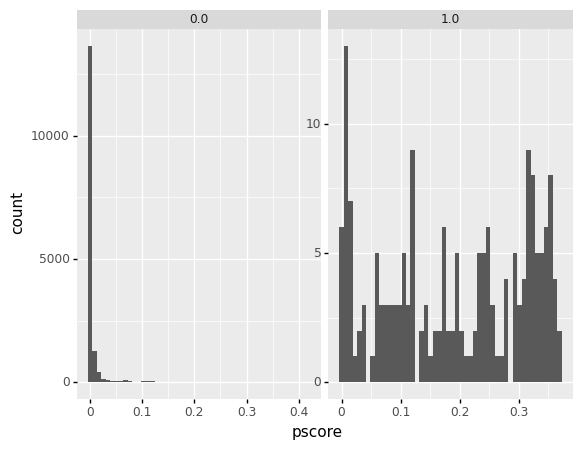

<ggplot: (8765026990550)>

In [12]:
# histogram
p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) +\
    p.geom_histogram(bins=50) +\
    p.facet_wrap("treat", scales='free')

#### Questions
- Compare the mean propensity score between the treated and the control groups. What does this reveal about the two groups?
- Compare the distribution of propensity scores between the treated and the control groups. How do they differ, if at all?


In [13]:
# continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol = nsw_dw_cpscontrol 
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        


Treatment Effect (non-normalized, all data): -11535.55


In [14]:
nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))
        

Treatment Effect (normalized, all data): -7044.80


In [15]:
nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))

Treatment Effect (non-normalized, trimmed data): 2486.22


In [16]:
nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (normalized, trimmed data): 423.62


#### Questions

- Explain the overlap condition in the context of these data.  How did we ensure that overlap held in the data? 
- When we are using non-trimmed data, why is the treatment effect negative? (*hint:* it has to do with extreme probability scores)
- What does this imply about the challenges of using non-experimental data when estimating causal effects, and why is conditioning on a trimmed propensity score important?


## Nearest-Neighbor Matching [not available in python]


#### Questions
- Compare our results from nearest-neighbor matching to what we found using the experimental data, the simple difference in outcomes using non-experimental controls, and propensity score weighting using non-experimental controls.
- DIFFICULT: Write a program that performs bootstrapping to get an estimate of the variance of the estimator. (HINT: Write a loop)

